In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random_utils import RandomGenerator

# Section 1.1 (Random Number Generation)

- I use numpy.random.default_rng to get the random number generator instance.
- The seed parameter allows for reproducible results, crucial for testing and debugging.
- `get_normal()` can return a single value or a NumPy array of specified size.

In [16]:
RandomGenerator?

Init signature: RandomGenerator(seed=None)
Docstring:     
Provides utilities for random number generation, 
primarily standard normal variables, i.e. N(0,1).
Init docstring:
Initializes the random number generator.
Args:
    seed(int, optional): Seed for the random number
    generator for reproducibility.
    Defaults to None (random seed).
File:           ~/Desktop/QuantProjects/MonteCarloExoticsPy/random_utils.py
Type:           type
Subclasses:     

In [17]:
RandomGenerator().get_normal(size=10)

array([ 1.72102218, -1.32999036,  0.90039587,  0.1396515 , -0.6964016 ,
        0.80906556, -0.86716628, -0.66425249, -1.10490638,  1.13129831])

In [18]:
RandomGenerator().get_uniform(size=10)

array([0.62725087, 0.41116251, 0.16727835, 0.70531141, 0.64613372,
       0.33640218, 0.6467878 , 0.13489555, 0.9004443 , 0.46588637])

# Section 1.2 (Path Simulation)


- Creates paths.
- `generate_path()`: Generates one path.
- `generate_paths_matrix()`: Generate multiple paths at once. This can be very beneficial for performance if payoff calculations can also be vectorized.

In [19]:
from path_simulator import PathSimulator 

In [20]:
PathSimulator?

Init signature:
PathSimulator(
    initial_price: float,
    risk_free_rate: float,
    dividend_yield: float,
    volatility: float,
    time_to_expiry: float,
    num_steps: float,
    random_generator: random_utils.RandomGenerator,
)
Docstring:      Simulates asset price path using GBM.
Init docstring:
Args:
    initial_price (S0)  : Initial asset price.
    risk_free_rate (r)  : Risk-free interest rate (annualized).
    dividend_yield (q)  : Continuous dividend yield (annualized).
    volatility (sigma)  : Asset price volatility (annualized).
    time_to_expiry (T)  : Time to option expiry in years.
    num_steps           : Number of time steps in the path.
    random_generator    : An instance of RandomGenerator.
File:           ~/Desktop/QuantProjects/MonteCarloExoticsPy/path_simulator.py
Type:           type
Subclasses:     

In [21]:
rng = RandomGenerator()
simulator = PathSimulator(initial_price=100.0, risk_free_rate=0.05, dividend_yield=0.01,
                            volatility=0.2, time_to_expiry=1.0, num_steps=252,
                            random_generator=rng)

single_path = simulator.generate_path()
print("Single Path (first 5 steps):", single_path[:5])
print("Single Path length:", len(single_path))

paths_mat = simulator.generate_paths_matrix(num_paths=3)
print("\nPaths Matrix (first 5 steps for 3 paths):\n", paths_mat[:, :5])
print("Paths Matrix shape:", paths_mat.shape)

Single Path (first 5 steps): [100.          99.42896214 100.81627173 102.28288008  99.89955856]
Single Path length: 253

Paths Matrix (first 5 steps for 3 paths):
 [[100.         101.33232349 102.08404412 100.55938962  99.09510394]
 [100.          99.40407051  97.35749985  98.38578132 101.22485826]
 [100.         101.4675257  100.38785136 100.47626754 101.14960061]]
Paths Matrix shape: (3, 253)


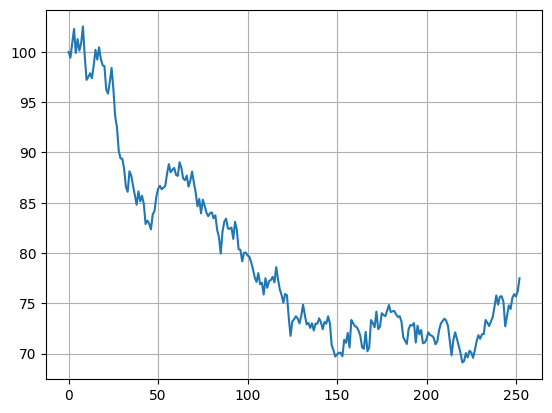

In [22]:
plt.plot(single_path)
plt.grid(True)

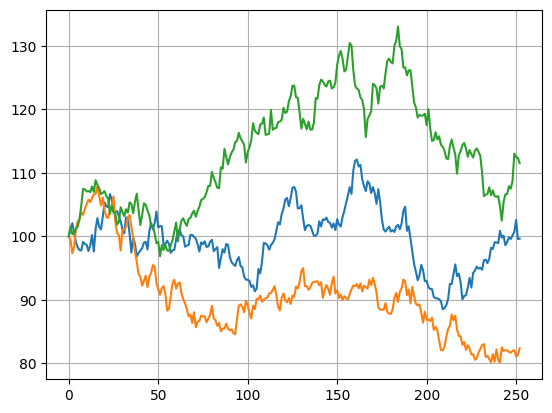

In [23]:
for val in paths_mat:
    plt.plot(val)
plt.grid(True)

# Section 1.3 (Options Models)



- `Option(ABC)`: Defines the interface with @abstractmethod decorators.
- `@property` for time_to_expiry provides a getter.
- `EuropeanOption`: Implements the payoff and option_type methods. The payoff uses asset_path[-1] for the terminal price.
- `OptionSide(Enum)`: Provides a typesafe way to specify Call or Put.

In [24]:
from options_models import EuropeanOption, OptionSide

In [25]:
dummy_path = np.array([100, 102, 105, 103, 107])

call_option = EuropeanOption(strike=105, time_to_expiry=1.0, side=OptionSide.CALL)
print(f"{call_option.option_type()} Payoff: {call_option.payoff(dummy_path)}")
print(f"Time to Expiry: {call_option.time_to_expiry}")

put_option = EuropeanOption(strike=105, time_to_expiry=1.0, side=OptionSide.PUT)
print(f"{put_option.option_type()} Payoff: {put_option.payoff(dummy_path)}")

European CALL Payoff: 2.0
Time to Expiry: 1.0
European PUT Payoff: 0.0


# Section 1.4 (Monte Carlo Engine)



- Takes an `Option` object and a `PathSimulator`.
- `run_simulations()`:
    - Generates paths and calculates payoffs.
    
    - Includes an option `use_vectorized_paths`. If True, it attempts to use the `generate_paths_matrix` method for potential speedup. The current implementation still loops through the rows of the matrix to call `option.payoff`. A more advanced version might have `option.payoff` itself accept a matrix of paths and return an array of payoffs, if the payoff logic can be vectorized with NumPy.
    
    - Calculates the average discounted payoff.
    
    - Also calculates the standard error of the mean, which is a good measure of the simulation's precision. `SE = stdev(Discounted Payoffs) / sqrt(N_sims)`.

In [32]:
from random_utils import RandomGenerator
from options_models import EuropeanOption, OptionSide
from mc_engine import MonteCarloEngine

rng_test = RandomGenerator()
sim_test = PathSimulator(100, 0.05, 0.01, 0.2, 1.0, 252, rng_test)
opt_test = EuropeanOption(strike=100, time_to_expiry=1.0, side=OptionSide.CALL)

engine_test = MonteCarloEngine(opt_test, sim_test, 0.05)

price, se = engine_test.run_simulations(1000)
print(f"Price (path-by-path): {price:.5f}, SE: {se:.5f}")

price_vec, se_vec = engine_test.run_simulations(1000, use_vectorized_paths=True)
print(f"Price (vectorized paths): {price_vec:.5f}, SE: {se_vec:.5f}")


Price (path-by-path): 9.51148, SE: 0.44802
Price (vectorized paths): 10.35125, SE: 0.46915
